In [20]:
import os, glob, pickle
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import cv2

from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras import utils
from tensorflow.keras.callbacks import EarlyStopping, Callback


from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, plot_confusion_matrix, confusion_matrix
from sklearn.preprocessing import LabelEncoder

from scripts import common_quick_plots as qp

np.random.seed(9)

### Phase 1 - Problem Definition  

#### 1.1 Broad Goals  

I have multiple small animals underfoot while I'm coding, cats and dogs.  While my dog is canine shaped and behaved, she is a small breed and ruff-ly the same size or smaller than my cat.  

#### 1.2 Data Source  

This project combines two open source datasets to create a single sample:  
    1. the [Stanford Dogs Dataset](http://vision.stanford.edu/aditya86/ImageNetDogs/) which includes a limited number of samples for each category and over 120 separate dog breeds.  
    2. the [Kaggle Cat Breeds Dataset](https://www.kaggle.com/ma7555/cat-breeds-dataset) which includes a limited number of samples for 67 different cat breeds

#### 1.3 Problem Statement 

While identifying which pet is at my feet is an easy task for me as a human, it becomes a larger challenge for a computer. This project aims to build a binary image classification model to check whether a pet is a cat or a dog from a photo, with a stretch goal of applying real-time testing to a webcam.

### Phase 2 - Data Gathering  
####    2.1 Loading Files

In [2]:
imgs = []

def load_resize(file, size = (160, 160)):
    # load file
    try:
        img_arr = cv2.imread(file)
        #convert to color array
        img_rgb = cv2.cvtColor(img_arr, cv2.COLOR_BGR2RGB)
        #reshape to uniform size 160x160x3
        new_array = cv2.resize(img_rgb, size)
        return new_array
    except:
        print(f"Invalid Path")

In [3]:
for path in glob.glob('./data/*'):
    species = os.path.basename(path)
    for breed in glob.glob(path +'/*'):
        # pull a simplified name
        if species == 'cat':
            breed_name = breed.split('/')[-1]
            for file in glob.glob(breed + '/*.jpg')[:350]: #limit to 350 per cat breed
                file_name = os.path.basename(file)
                # load file
                image = load_resize(file)
                imgs.append({'species' : species, 
                             'breed': breed_name, 
                             'image' : image
                            })
        else:
            breed_name = breed.split('-')[-1]
            for file in glob.glob(breed + '/*.jpg')[:150]: #limit to 150 per dog breed
                file_name = os.path.basename(file)
                # load file
                image = load_resize(file)
                imgs.append({'species' : species, 
                             'breed': breed_name, 
                             'image' : image
                            })

                
#convert list to dataframe
df = pd.DataFrame.from_dict(imgs)

Invalid Path
Invalid Path


In [4]:
df.head()

,species,breed,image
0,cat,Chausie,"[[[205, 206, 210], [206, 207, 211], [212, 213,..."
1,cat,Chausie,"[[[46, 62, 75], [45, 61, 76], [45, 58, 74], [4..."
2,cat,Chausie,"[[[163, 195, 236], [147, 179, 220], [129, 162,..."
3,cat,Chausie,"[[[248, 206, 210], [252, 211, 215], [247, 206,..."
4,cat,Chausie,"[[[181, 169, 153], [185, 173, 157], [188, 176,..."


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33104 entries, 0 to 33103
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   species  33104 non-null  object
 1   breed    33104 non-null  object
 2   image    33102 non-null  object
dtypes: object(3)
memory usage: 776.0+ KB


### Phase 3 - Exploratory Data Analysis  

#### 3.1 Dataset Shape

In [6]:
df['species'].value_counts()

dog    17997
cat    15107
Name: species, dtype: int64

In [7]:
df['species'].value_counts(normalize = True)

dog    0.54365
cat    0.45635
Name: species, dtype: float64

#### 3.2 Sample Images

In [8]:
sample_images = df['image'].sample(9).copy()

#### 3.3 Principal Component Analysis

### Phase 4 - Modeling  

#### 4.1 Train/Test/Split

In [9]:
X = []
y = []
for path in glob.glob('./data/*'):
    species = os.path.basename(path)
    for breed in glob.glob(path +'/*'):
        # pull a simplified name
        if species == 'cat':
            breed_name = breed.split('/')[-1]
            for file in glob.glob(breed + '/*.jpg')[:350]: #limit to 350 per cat breed
                file_name = os.path.basename(file)
                # load file
                try:
                    size = (160, 160)
                    img_arr = cv2.imread(file)
                    #convert to color array
                    img_rgb = cv2.cvtColor(img_arr, cv2.COLOR_BGR2RGB)
                    #reshape to uniform size 160x160x3
                    new_array = cv2.resize(img_rgb, size)
                    X.append(new_array)
                    y.append(1)
                except:
                    print(f"Invalid Path")
        else:
            breed_name = breed.split('-')[-1]
            for file in glob.glob(breed + '/*.jpg')[:150]: #limit to 150 per dog breed
                file_name = os.path.basename(file)
                # load file
                try:
                    size = (160, 160)
                    img_arr = cv2.imread(file)
                    #convert to color array
                    img_rgb = cv2.cvtColor(img_arr, cv2.COLOR_BGR2RGB)
                    #reshape to uniform size 160x160x3
                    new_array = cv2.resize(img_rgb, size)
                    X.append(new_array)
                    y.append(0)
                except:
                    print(f"Invalid Path")

Invalid Path
Invalid Path


In [10]:
X = np.array(X)
y = np.array(y)

X.shape, y.shape


((33102, 160, 160, 3), (33102,))

In [11]:
X = X.astype('float32')
y = utils.to_categorical(y, 2)

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 9)

#### 4.2 Convolutional Neural Net

In [13]:
cnn = Sequential()
# Starting Layer
cnn.add(Conv2D(filters = 128,
               kernel_size = (3, 3),
               activation = 'relu',
               input_shape = (160, 160, 3)))
cnn.add(MaxPooling2D(pool_size = (2,2)))
#second convolutional layer
cnn.add(Conv2D(filters=64,            
                     kernel_size=(3, 3),        
                     activation='relu'))
cnn.add(MaxPooling2D(pool_size=(2,2)))

#third convolutional layer
cnn.add(Conv2D(filters=128,            
                     kernel_size=(3, 3),        
                     activation='relu'))
cnn.add(MaxPooling2D(pool_size=(2,2)))

#fourth convolutional layer
cnn.add(Conv2D(filters=32,            
                     kernel_size=(3, 3),        
                     activation='relu'))
cnn.add(MaxPooling2D(pool_size=(2,2)))

#fifth convolutional layer
cnn.add(Conv2D(filters=32,            
                     kernel_size=(3, 3),        
                     activation='relu'))
cnn.add(MaxPooling2D(pool_size=(2,2)))


#flatten the metrics to fit into the Dense layers 
cnn.add(Flatten())
cnn.add(Dense(32, activation = 'relu'))
cnn.add(Dropout(0.3))
cnn.add(Dense(256, activation = 'relu'))
cnn.add(Dropout(0.3))
cnn.add(Dense(128, activation = 'relu'))
cnn.add(Dropout(0.3))
cnn.add(Dense(64, activation = 'relu'))
cnn.add(Dropout(0.3))
cnn.add(Dense(32, activation = 'relu'))
cnn.add(Dense(2, activation = 'sigmoid'))
cnn.compile(loss = 'binary_crossentropy',
             optimizer = 'adam',
             metrics = ['accuracy'])
early_stop = EarlyStopping(patience = 5, restore_best_weights = True)

In [14]:
cnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 158, 158, 128)     3584      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 79, 79, 128)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 77, 77, 64)        73792     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 38, 38, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 36, 36, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 18, 18, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 32)        3

In [15]:
res = cnn.fit(X_train, y_train,
             batch_size = 64,
             validation_data = (X_test, y_test),
             epochs = 30,
             callbacks = [early_stop],
             verbose = 1)

Train on 24826 samples, validate on 8276 samples
Epoch 1/30
24826/24826 [==============================] - 873s 35ms/sample - loss: 0.6080 - accuracy: 0.6565 - val_loss: 0.3668 - val_accuracy: 0.8398
Epoch 2/30
24826/24826 [==============================] - 860s 35ms/sample - loss: 0.3168 - accuracy: 0.8696 - val_loss: 0.2458 - val_accuracy: 0.9134
Epoch 3/30
24826/24826 [==============================] - 828s 33ms/sample - loss: 0.2398 - accuracy: 0.9062 - val_loss: 0.2564 - val_accuracy: 0.9022
Epoch 4/30
24826/24826 [==============================] - 819s 33ms/sample - loss: 0.2094 - accuracy: 0.9200 - val_loss: 0.1944 - val_accuracy: 0.9286
Epoch 5/30
24826/24826 [==============================] - 853s 34ms/sample - loss: 0.2023 - accuracy: 0.9221 - val_loss: 0.1847 - val_accuracy: 0.9319
Epoch 6/30
24826/24826 [==============================] - 847s 34ms/sample - loss: 0.2002 - accuracy: 0.9229 - val_loss: 0.1766 - val_accuracy: 0.9368
Epoch 7/30
24826/24826 [=====================

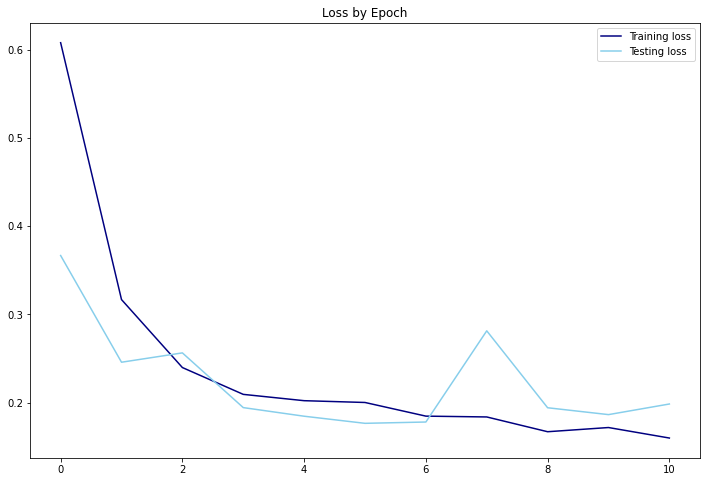

In [16]:
qp.plot_loss(res, 'Loss by Epoch')
plt.savefig('./imgs/lossXepoch.jpg');

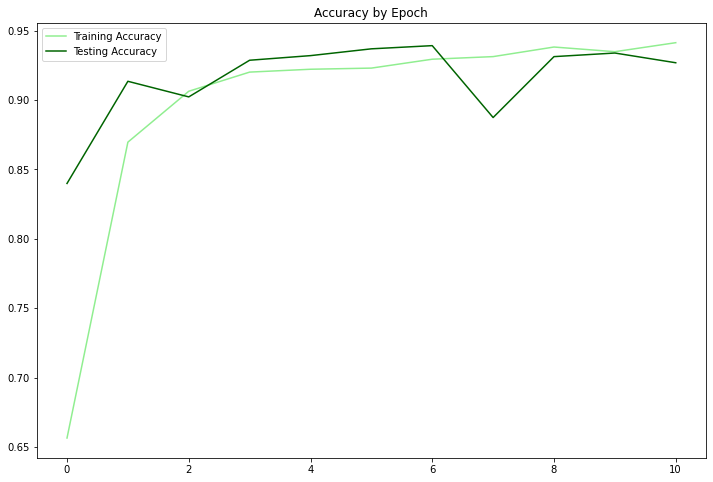

In [17]:
qp.plot_accuracy(res, 'Accuracy by Epoch')
plt.savefig('./imgs/accXepoch.jpg');

In [18]:
cnn.save('./model')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: ./model/assets


In [21]:
cnn2 = load_model('./model')